In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', '1s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')


In [3]:
aclew_measures

,recording_filename,segment_onset,segment_offset,child_id,duration_alice,wc_fem,wc_mal,wc_adu,duration_vcm,non_can_voc_CHI,can_voc_CHI,can_voc_dur_CHI,duration_vtc,voc_dur_chi,voc_chi,avg_voc_dur_chi,5s_CTC,speechlike_pitch,nonspeechlike_pitch,group_id
0,20180530_181655_022873.wav,1639000,1759000,3321,120000,58.72,0.88,59.60,120000,5,0,0.0,120000,87287.0,26,3357.192308,30,"[228.48704510485052, 486.9420404296455, 394.43...","[284.12270707020286, 403.0400608703906, 429.70...",low_risk
1,20180530_181655_022873.wav,2072000,2192000,3321,120000,40.38,0.00,40.38,120000,16,1,2567.0,120000,39934.0,18,2218.555556,9,"[518.8369582195888, 409.8143921244038, 283.117...",[372.2728234468482],low_risk
2,20180530_181655_022873.wav,2202000,2322000,3321,120000,46.32,7.72,54.04,120000,10,0,0.0,120000,14344.0,11,1304.000000,9,"[nan, nan, 326.60608559543766, 397.34887006092...",[456.42752176149645],low_risk
3,20180530_181655_022873.wav,5817000,5937000,3321,120000,33.58,0.00,33.58,120000,8,0,0.0,120000,8855.0,8,1106.875000,4,"[471.73529298938456, 455.77709433980056, 351.3...",[],low_risk
4,20180530_181655_022873.wav,6620000,6740000,3321,120000,61.70,0.00,61.70,120000,11,0,0.0,120000,21314.0,14,1522.428571,4,"[474.5115338430446, 323.3997502281562, 300.831...","[567.1308660183602, 510.45102362133207, 384.10...",low_risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,20231025_115855_045737_2.wav,16289000,16409000,6731,120000,126.16,43.31,169.47,120000,15,3,3192.0,120000,18118.0,19,953.578947,30,"[364.9781975528883, 294.2447392710183, 348.063...",[504.7319520767478],low_risk
746,20231025_115855_045737_2.wav,16567000,16687000,6731,120000,25.11,4.85,29.96,120000,7,1,2359.0,120000,63934.0,15,4262.266667,13,"[408.4288605221903, 382.6535837739436, 275.534...","[429.43839439959316, 435.55151519713627, 355.3...",low_risk
747,20231025_115855_045737_2.wav,18264000,18384000,6731,120000,0.00,0.00,0.00,120000,0,0,0.0,120000,0.0,0,0.000000,0,[],[],low_risk
748,20231025_115855_045737_2.wav,28611000,28731000,6731,120000,37.17,30.55,67.72,120000,8,1,2609.0,120000,16329.0,10,1632.900000,13,"[356.64924857986443, 555.4325081117244, 435.47...",[376.9298446973081],low_risk


In [5]:
import pandas as pd
import numpy as np
from scipy import stats

def analyze_clip_numbers(auto_data, manual_data, measure, metric='pearson', max_clips=15, n_iterations=1000):
    """
    Analyze how correlation or relative error stabilizes as number of clips increases
    """
    recordings = auto_data['recording_filename'].unique()
    results = []
    
    for n_clips in range(1, max_clips + 1):
        print(f"Processing n_clips = {n_clips}")
        metric_values = []
        
        for i in range(n_iterations):
            auto_sums = []
            manual_sums = []
            
            for recording in recordings:
                auto_rec = auto_data[auto_data['recording_filename'] == recording]
                manual_rec = manual_data[manual_data['recording_filename'] == recording]
                
                if len(auto_rec) >= n_clips:
                    indices = np.random.choice(len(auto_rec), size=n_clips, replace=True)
                    auto_sum = auto_rec.iloc[indices][measure].sum()
                    manual_sum = manual_rec.iloc[indices][measure].sum()
                    
                    auto_sums.append(auto_sum)
                    manual_sums.append(manual_sum)
            
            # Calculate metric
            if metric == 'pearson':
                if len(auto_sums) >= 2:  # Need at least 2 points for correlation
                    value = stats.pearsonr(auto_sums, manual_sums)[0]
                    metric_values.append(value)
            else:  # relative error
                errors = []
                for auto, manual in zip(auto_sums, manual_sums):
                    if manual == 0 and auto == 0:
                        error = 0  # Perfect agreement when both are zero
                    elif manual == 0:
                        error = 1  # Maximum error when manual is zero but auto isn't
                    else:
                        error = (auto - manual) / manual
                    errors.append(error)
                value = np.mean(errors)
                metric_values.append(value)
        
        results.append({
            'n_clips': n_clips,
            f'{metric}_mean': np.mean(metric_values),
            f'{metric}_std': np.std(metric_values),
            'ci_lower': np.percentile(metric_values, 2.5),
            'ci_upper': np.percentile(metric_values, 97.5)
        })
        
        print(f"  Mean {metric}: {np.mean(metric_values):.3f}")
    
    return pd.DataFrame(results)
    
    
metric = 'pearson'
results_mape_aclew = analyze_clip_numbers(aclew_measures, human_measures, 
                                          measure='5s_CTC', metric=metric, 
                                          n_iterations=250)

results_mape_lena = analyze_clip_numbers(lena_measures, human_measures, 
                                         measure='5s_CTC', metric=metric, 
                                         n_iterations=250)

Processing n_clips = 1
  Mean pearson: 0.839
Processing n_clips = 2
  Mean pearson: 0.849
Processing n_clips = 3
  Mean pearson: 0.865
Processing n_clips = 4
  Mean pearson: 0.872
Processing n_clips = 5
  Mean pearson: 0.875
Processing n_clips = 6
  Mean pearson: 0.883
Processing n_clips = 7
  Mean pearson: 0.882
Processing n_clips = 8
  Mean pearson: 0.883
Processing n_clips = 9
  Mean pearson: 0.890
Processing n_clips = 10
  Mean pearson: 0.892
Processing n_clips = 11
  Mean pearson: 0.892
Processing n_clips = 12
  Mean pearson: 0.897
Processing n_clips = 13
  Mean pearson: 0.895
Processing n_clips = 14
  Mean pearson: 0.898
Processing n_clips = 15
  Mean pearson: 0.899
Processing n_clips = 1
  Mean pearson: 0.695
Processing n_clips = 2
  Mean pearson: 0.729
Processing n_clips = 3
  Mean pearson: 0.737
Processing n_clips = 4
  Mean pearson: 0.754
Processing n_clips = 5
  Mean pearson: 0.759
Processing n_clips = 6
  Mean pearson: 0.775
Processing n_clips = 7
  Mean pearson: 0.781
Proc

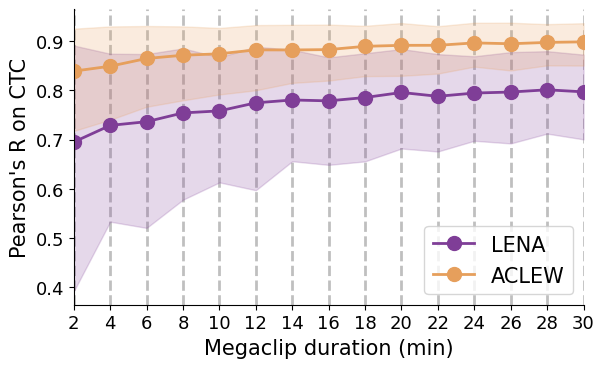

In [20]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 13, 'ytick.labelsize': 13})
lena_color = '#7F3E97'
aclew_color = '#E69F5C'

def plot_metric_results(results_lena, results_aclew, extra_y='', metric='pearson'):
    """
    Plot results with confidence intervals
    
    Parameters:
    -----------
    results : pd.DataFrame
        DataFrame containing results
    metric : str
        'pearson' for correlation or 'mape' for MAPE results
    """
    metric_col = f'{metric}_mean'
    lena_color = '#7F3E97'
    aclew_color = '#E69F5C'

    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))

    ax.plot(results_lena['n_clips']*2, results_lena[metric_col], 'o-', color=lena_color, linewidth=2, label=f'LENA')
    ax.plot(results_aclew['n_clips']*2, results_aclew[metric_col], 'o-', color=aclew_color, linewidth=2, label=f'ACLEW')

    ax.fill_between(results_lena['n_clips']*2,
                     results_lena['ci_lower'],
                     results_lena['ci_upper'],
                     alpha=0.2, color=lena_color)

    ax.fill_between(results_aclew['n_clips']*2,
                     results_aclew['ci_lower'],
                     results_aclew['ci_upper'],
                     alpha=0.2, color=aclew_color)
    
    ax.set_xlabel('Megaclip duration (min)')
    ax.set_ylabel(f"Pearson's R{extra_y}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(np.arange(2, 32, 2))
    ax.set_xlim(2,30)
    # Add vertical dashed lines every 2 minutes
    for t in range(2, 32, 2):
        ax.axvline(x=t, color='gray', linestyle='--', alpha=0.5, zorder=-5)
    ax.legend()
    plt.tight_layout()
    plt.savefig('/home/engaclew/neurogen/figures/bootstrapping_lena_aclew.png', dpi=300)
    plt.show()

metric='pearson'
plot_metric_results(results_mape_lena, results_mape_aclew, extra_y=' on CTC', metric=metric)


In [51]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def analyze_time_intervals(auto_data, manual_data, measure, base_interval=2, max_interval=30):
    nb_clips = len(auto_data)
    auto_data_tmp = auto_data.sort_values(by=['recording_filename', 'segment_onset']).copy()
    manual_data_tmp = manual_data.sort_values(by=['recording_filename', 'segment_onset']).copy()
    out = []
    clip_dur = 2
    
    # First iteration with original 2-min clips
    auto_measures = auto_data_tmp[measure]
    manual_measures = manual_data_tmp[measure]
    out.append({'pearson': stats.pearsonr(auto_measures, manual_measures)[0], 'duration': clip_dur, 'nb_clips': len(auto_data)})
    while clip_dur < max_interval:
        # Increase duration by 2 minutes
        clip_dur += 2
        
        # Create new dataframes for the current duration
        auto_combined = []
        manual_combined = []
        
        # Group by recording filename
        for filename, group in auto_data.groupby('recording_filename'):
            # Sort by segment_onset within each group
            group = group.sort_values('segment_onset')
            
            # Number of original 2-min clips to combine
            n_clips_to_combine = clip_dur // 2
            
            # Process each group in chunks of n_clips_to_combine
            for i in range(0, len(group), n_clips_to_combine):
                chunk = group.iloc[i:i+n_clips_to_combine]
                
                # Only use complete chunks matching our target duration
                if len(chunk) == n_clips_to_combine:
                    combined_row = chunk.iloc[0].copy()
                    combined_row['segment_offset'] = chunk.iloc[-1]['segment_offset']
                    combined_row[measure] = chunk[measure].sum()
                    auto_combined.append(combined_row)
        
        # Do the same for manual data
        for filename, group in manual_data.groupby('recording_filename'):
            group = group.sort_values('segment_onset')
            n_clips_to_combine = clip_dur // 2
            
            for i in range(0, len(group), n_clips_to_combine):
                chunk = group.iloc[i:i+n_clips_to_combine]
                if len(chunk) == n_clips_to_combine:
                    combined_row = chunk.iloc[0].copy()
                    combined_row['segment_offset'] = chunk.iloc[-1]['segment_offset']
                    combined_row[measure] = chunk[measure].sum()
                    manual_combined.append(combined_row)
        # Convert to dataframes
        auto_combined_df = pd.DataFrame(auto_combined)
        manual_combined_df = pd.DataFrame(manual_combined)

        # Calculate correlation if we have data
        if len(auto_combined_df) > 0 and len(manual_combined_df) > 0:
            auto_measures = auto_combined_df[measure]
            manual_measures = manual_combined_df[measure]
            out.append({'pearson': stats.pearsonr(auto_measures, manual_measures)[0], 'duration': clip_dur, 'nb_clips': len(auto_combined_df)})
            
            print(f"\n{clip_dur}-minute clips ({len(auto_combined_df)} clips):")
    
    return pd.DataFrame(out)

# For LENA data
results_lena = analyze_time_intervals(lena_measures, human_measures, 
                                   measure='5s_CTC',
                                   base_interval=2,
                                   max_interval=30)

# For ACLEW data
results_aclew = analyze_time_intervals(aclew_measures, human_measures, 
                                    measure='5s_CTC',
                                    base_interval=2,
                                    max_interval=30)


results_aclew


4-minute clips (350 clips):

6-minute clips (250 clips):

8-minute clips (150 clips):

10-minute clips (150 clips):

12-minute clips (100 clips):

14-minute clips (100 clips):

16-minute clips (50 clips):

18-minute clips (50 clips):

20-minute clips (50 clips):

22-minute clips (50 clips):

24-minute clips (50 clips):

26-minute clips (50 clips):

28-minute clips (50 clips):

30-minute clips (50 clips):

4-minute clips (350 clips):

6-minute clips (250 clips):

8-minute clips (150 clips):

10-minute clips (150 clips):

12-minute clips (100 clips):

14-minute clips (100 clips):

16-minute clips (50 clips):

18-minute clips (50 clips):

20-minute clips (50 clips):

22-minute clips (50 clips):

24-minute clips (50 clips):

26-minute clips (50 clips):

28-minute clips (50 clips):

30-minute clips (50 clips):


,pearson,duration,nb_clips
0,0.835966,2,750
1,0.855197,4,350
2,0.852322,6,250
3,0.868905,8,150
4,0.887041,10,150
5,0.875974,12,100
6,0.902185,14,100
7,0.889447,16,50
8,0.883515,18,50
9,0.894727,20,50


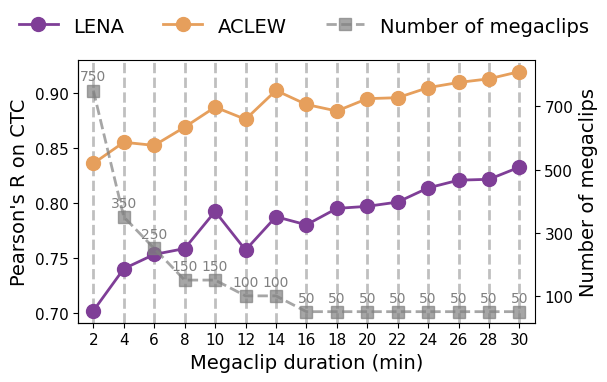

In [88]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14, 'legend.handleheight': 1, 'hatch.linewidth': 1.0,
                          'lines.markersize': 10, 'lines.linewidth': 2, 'errorbar.capsize': 5,
                           'xtick.labelsize': 11, 'ytick.labelsize': 11})

def plot_results(results_lena, results_aclew, extra_y='', metric='pearson'):
    metric_col = f'{metric}'
    lena_color = '#7F3E97'
    aclew_color = '#E69F5C'
    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 10*cm))
    
    # Main lines for Pearson's R
    ax.plot(results_lena['duration'], results_lena[metric_col], 'o-', color=lena_color, linewidth=2, label=f'LENA')
    ax.plot(results_lena['duration'], results_aclew[metric_col], 'o-', color=aclew_color, linewidth=2, label=f'ACLEW')
    
    # Create a secondary y-axis for number of clips
    ax2 = ax.twinx()
    ax2.plot(results_lena['duration'], results_lena['nb_clips'], 's--', color='gray', alpha=0.7, markersize=8, label='Number of megaclips')
    ax2.set_ylabel('Number of megaclips')
    
    # Add clip count labels above the points
    for i, row in results_lena.iterrows():
        ax2.annotate(f"{int(row['nb_clips'])}", 
                     xy=(row['duration'], 10+row['nb_clips']),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center',
                     fontsize=10,
                     color='gray')
    
    # Main axis settings
    ax.set_xlabel('Megaclip duration (min)')
    ax.set_ylabel(f"Pearson's R{extra_y}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(np.arange(2, 32, 2))
    ax.set_xlim(2, 30)
    min_y, max_y = ax2.get_ylim()
    ax2.set_ylim(min_y, max_y*1.08)
    ax2.set_yticks([700, 500, 300, 100])
    # Add vertical dashed lines every 2 minutes
    for t in range(2, 32, 2):
        ax.axvline(x=t, color='gray', linestyle='--', alpha=0.5, zorder=-5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(1,31)
    # Create a combined legend and place it above the graph
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, 
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.0),
               ncol=3,  # Display legend items in 3 columns
               frameon=False)  # Remove the legend frame
    
    # Adjust the top margin to make room for the legend
    plt.subplots_adjust(top=0.85)
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust the rect parameter to make room for the legend
    plt.savefig('/home/engaclew/neurogen/figures/pearson_duration_lena_aclew.png', dpi=300)
    plt.show()
# Plot results
metric='pearson'
plot_results(results_lena, results_aclew, extra_y=' on CTC', metric=metric)

In [17]:
results_lena

,interval_minutes,n_clips,actual_n_clips,pearson
0,2,750.000000,750,0.702363
1,4,375.000000,350,0.740509
2,6,250.000000,250,0.753447
3,8,187.500000,150,0.758775
4,10,150.000000,150,0.792450
5,12,125.000000,100,0.757451
6,14,107.142857,100,0.787661
7,16,93.750000,50,0.780302
8,18,83.333333,50,0.795189
9,20,75.000000,50,0.797074


In [7]:
results_lena

,interval_minutes,n_clips,actual_n_clips,pearson_r,p_value,mean_auto,mean_manual,mape
0,2,750.000000,750,0.702363,1.548887e-112,1.342667,6.212000,43.951166
1,4,375.000000,350,0.740509,4.957617e-62,2.728571,12.242857,55.247438
2,6,250.000000,250,0.753447,4.629843e-47,4.028000,18.636000,63.360144
3,8,187.500000,150,0.758775,2.391172e-29,5.793333,26.400000,72.236629
4,10,150.000000,150,0.792450,1.372688e-33,6.713333,31.060000,69.978506
5,12,125.000000,100,0.757451,7.536113e-20,8.690000,39.600000,70.163304
6,14,107.142857,100,0.787661,2.469935e-22,9.550000,42.850000,69.403660
7,16,93.750000,50,0.780302,2.382701e-11,12.920000,58.080000,74.169148
8,18,83.333333,50,0.795189,5.306217e-12,14.080000,62.920000,74.565828
9,20,75.000000,50,0.797074,4.349157e-12,15.080000,68.000000,74.509921
